In [1]:
#Import thư viện
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from collections import Counter
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import roc_auc_score
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt


In [2]:
#Tải bộ dữ liệu
df = pd.read_csv('Data/train.csv')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


===DATA PREPARATION

In [3]:
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [4]:
#Đổi sang số
month_mapping = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
df['month'] = df['month'].str.lower().map(month_mapping)

In [5]:
#EDA dữ liệu gốc
#--Kiểm tra dữ liệu rỗng
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  int64 
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


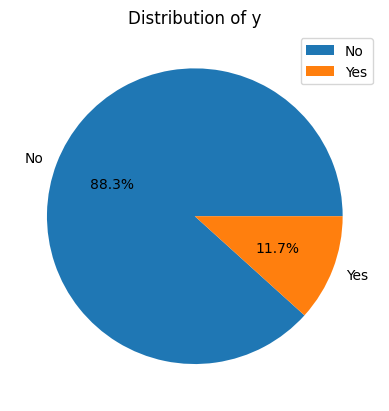

In [7]:
#--Kiểm tra tỉ lệ của biến phụ thuộc
def check_ratio(column_name, labls):
    values = df[column_name].value_counts()
    label = labls
    plt.pie(values, labels=label, autopct='%1.1f%%')
    plt.title(f'Distribution of {column_name}')
    plt.legend()
    plt.show()
check_ratio('y', ['No','Yes'])

=>> Chênh lệch rấy lớn giữa 2 giá trị, cần phải xử lí để tránh bias

In [8]:
#%% Mã hóa dữ liệu
def handle_nominal_data(dataframe, column_name):
    dummy_variables = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dummy_variables = dummy_variables.astype(int)
    merged_dataframe = pd.concat([dataframe, dummy_variables], axis=1)
    merged_dataframe = merged_dataframe.drop(columns=[column_name])
    return merged_dataframe

In [9]:
#%% - Chuyển đổi dữ liệu sang thứ bậc
low_threshold = df['duration'].quantile(0.25)
high_threshold = df['duration'].quantile(0.75)

In [10]:
# Phân loại duration vào các thang đo tương ứng
def classify_duration_score(score):
    if score <= low_threshold:
        return 'Short'
    elif score <= high_threshold:
        return 'Medium'
    else:
        return 'Long'

In [11]:
# Tạo cột mới cho thang đo duration
df['duration_group'] = df['duration'].apply(classify_duration_score)

In [12]:
#Mã hóa dữ liệu
merged_dataframe = handle_nominal_data(df,'education')

In [13]:
merged_dataframe = merged_dataframe.drop('duration', axis=1)
merged_dataframe = handle_nominal_data(merged_dataframe,'job')
merged_dataframe = handle_nominal_data(merged_dataframe,'marital')
merged_dataframe = handle_nominal_data(merged_dataframe,'poutcome')
merged_dataframe = handle_nominal_data(merged_dataframe,'contact')
merged_dataframe = handle_nominal_data(merged_dataframe,'duration_group')

In [14]:
#%% Mã hóa dữ liệu 
merged_dataframe['default'] = merged_dataframe['default'].map({'yes': 1, 'no':0})
merged_dataframe['housing'] = merged_dataframe['housing'].map({'yes': 1, 'no':0})
merged_dataframe['loan'] = merged_dataframe['loan'].map({'yes': 1, 'no':0})
merged_dataframe['y'] = merged_dataframe['y'].map({'yes': 1, 'no':0})

In [15]:
#%% Sử dụng Standard Scaler chuẩn hóa dữ liệu
# Khởi tạo StandardScaler
scaler = StandardScaler()

In [16]:
# Chọn cột để chuẩn hóa
columns_to_scale = ['age', 'balance', 'duration']

In [17]:
# Chuẩn hóa dữ liệu trong các cột đã chọn
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [18]:
df[columns_to_scale].head()

,age,balance,duration
0,1.606965,0.256419,0.011016
1,0.288529,-0.437895,-0.416127
2,-0.747384,-0.446762,-0.707361
3,0.571051,0.047205,-0.645231
4,-0.747384,-0.447091,-0.233620


In [20]:
##Drop biến nền
merged_dataframe=merged_dataframe.drop(columns=['duration_group_Long','education_primary','job_admin.','marital_single','poutcome_success','contact_telephone'])

In [53]:
merged_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   age                    45211 non-null  int64
 1   default                45211 non-null  int64
 2   balance                45211 non-null  int64
 3   housing                45211 non-null  int64
 4   loan                   45211 non-null  int64
 5   day                    45211 non-null  int64
 6   month                  45211 non-null  int64
 7   campaign               45211 non-null  int64
 8   pdays                  45211 non-null  int64
 9   previous               45211 non-null  int64
 10  y                      45211 non-null  int64
 11  education_secondary    45211 non-null  int32
 12  education_tertiary     45211 non-null  int32
 13  education_unknown      45211 non-null  int32
 14  job_blue-collar        45211 non-null  int32
 15  job_entrepreneur       45211 non-nul

In [21]:
# Khai báo biến độc lập và biến phụ thuộc
X = merged_dataframe.drop(columns=['y'])
y = merged_dataframe['y']

##ĐA BIẾN

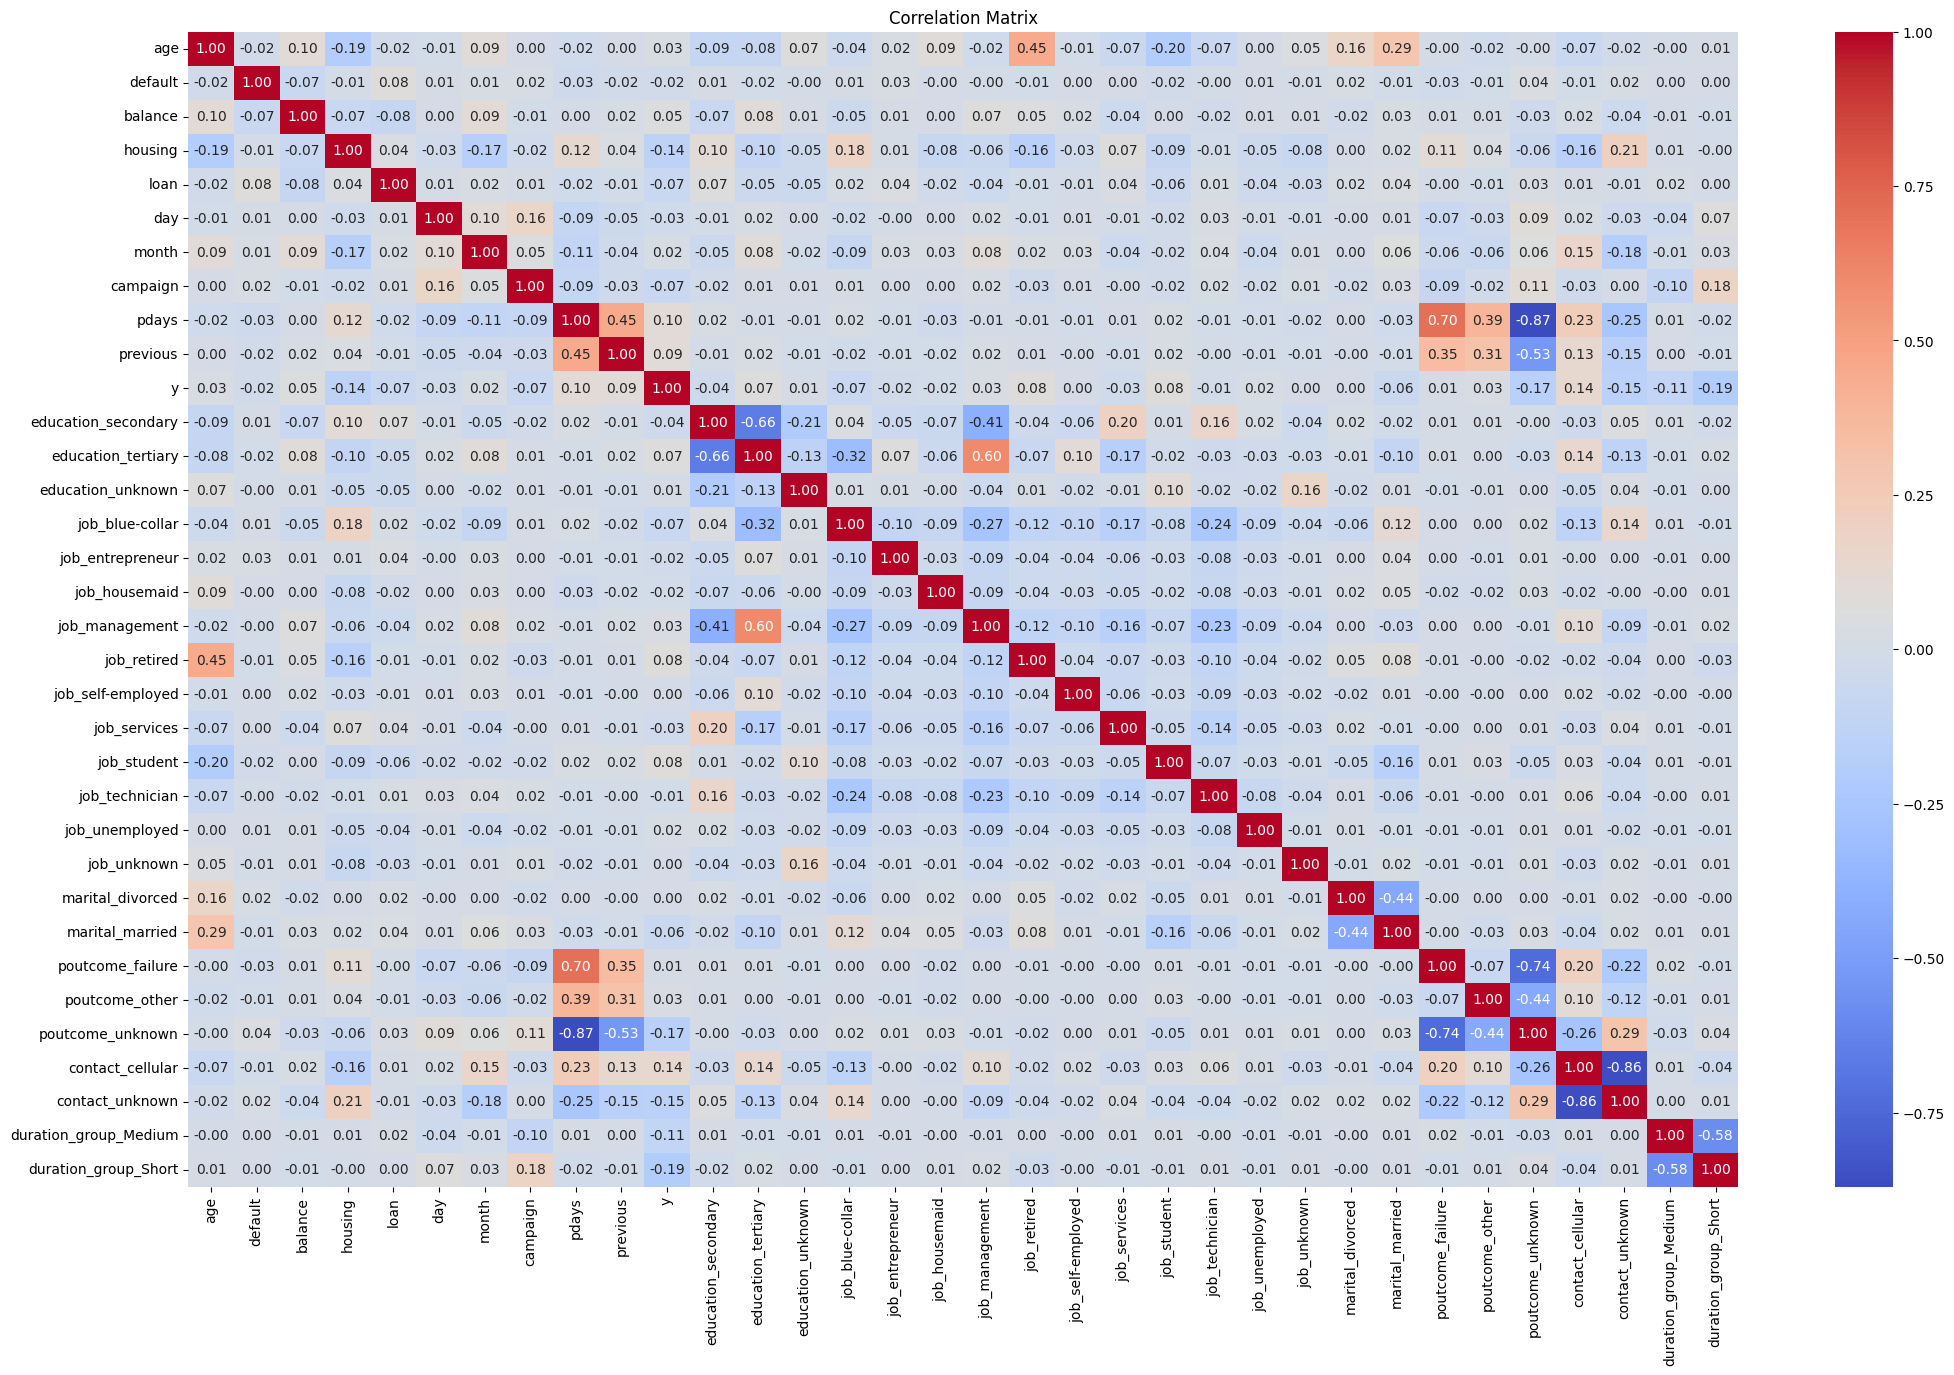

In [22]:
#%% Tính độ tương quan
def correlation_matrix(dataframe):
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(25, 15))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()
correlation_matrix(merged_dataframe)

In [23]:
merged_dataframe.head()

,age,default,balance,housing,loan,day,month,campaign,pdays,previous,...,job_unknown,marital_divorced,marital_married,poutcome_failure,poutcome_other,poutcome_unknown,contact_cellular,contact_unknown,duration_group_Medium,duration_group_Short
0,58,0,2143,1,0,5,5,1,-1,0,...,0,0,1,0,0,1,0,1,1,0
1,44,0,29,1,0,5,5,1,-1,0,...,0,0,0,0,0,1,0,1,1,0
2,33,0,2,1,1,5,5,1,-1,0,...,0,0,1,0,0,1,0,1,0,1
3,47,0,1506,1,0,5,5,1,-1,0,...,0,0,1,0,0,1,0,1,0,1
4,33,0,1,0,0,5,5,1,-1,0,...,1,0,0,0,0,1,0,1,1,0


In [24]:
#%% Chọn biến
def feature_selection(dataframe):
    feature = list(dataframe.columns[:9])
    return feature
features = feature_selection(dataframe=merged_dataframe)

In [25]:
#%% Kiểm định ANOVA
def ANOVA_test(x,y):
    selector = SelectKBest(f_classif, k=4)
    selector.fit(x, y)

    x_new = selector.transform(x)
    final_features = df.columns[selector.get_support(indices=True)].tolist()
    return final_features
ANOVA_test(x=merged_dataframe[features], y=merged_dataframe['y'])

['education', 'default', 'loan', 'contact']

In [26]:
#%% Kiểm định VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    return vif_data

In [27]:
# Calculate VIF
vif_results = calculate_vif(X)
print(vif_results)

                  Feature        VIF
0                     age  21.054303
1                 default   1.032682
2                 balance   1.249469
3                 housing   2.688177
4                    loan   1.229682
5                     day   4.711817
6                   month   7.916620
7                campaign   1.931205
8                   pdays   4.606862
9                previous   1.465247
10    education_secondary   4.793124
11     education_tertiary   4.415576
12      education_unknown   1.330677
13        job_blue-collar   2.967338
14       job_entrepreneur   1.334034
15          job_housemaid   1.295287
16         job_management   3.741458
17            job_retired   1.785952
18      job_self-employed   1.351352
19           job_services   1.754485
20            job_student   1.207497
21         job_technician   2.436428
22         job_unemployed   1.243279
23            job_unknown   1.094854
24       marital_divorced   1.627028
25        marital_married   3.983646
2

In [28]:
#%%- Oversampling
def conduct_oversampling(x,y):
    oversample = SMOTE()
    x_oversampled, y_oversampled = oversample.fit_resample(x, y)
    counter = Counter(y)
    return x_oversampled,y_oversampled

In [29]:
x,y = merged_dataframe[['loan', 'balance', 'default', 'pdays']], merged_dataframe['y']

In [30]:
#%% Huấn luyện, dự báo và đánh giá mô hình
def train_predict_and_evaluate_model(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    x_train,y_train= conduct_oversampling(x_train, y_train)
    x_train = sm.add_constant(x_train)
    # Fit the logistic regression model
    logit_model = sm.Logit(y_train, x_train)
    # Print the summary of the model
    result = logit_model.fit()
    time.sleep(0.3)
    # Predicting the test set results
    y_pred = result.predict(sm.add_constant(x_test))
    y_pred = (y_pred > 0.5)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate precision
    precision = precision_score(y_test, y_pred)

    # Calculate recall
    recall = recall_score(y_test, y_pred)
    #Calculate f1 score
    f1 = f1_score(y_test,y_pred)
    #roc-auc
    roc_auc = roc_auc_score(y_test, y_pred)
    return result.summary(), cm, accuracy, precision, recall, f1, roc_auc

print(train_predict_and_evaluate_model(x,y))



Optimization terminated successfully.
         Current function value: 0.650006
         Iterations 6
(<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                63940
Model:                          Logit   Df Residuals:                    63935
Method:                           MLE   Df Model:                            4
Date:                Fri, 09 Aug 2024   Pseudo R-squ.:                 0.06224
Time:                        16:04:36   Log-Likelihood:                -41561.
converged:                       True   LL-Null:                       -44320.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0317      0.010     -3.034      0.002     

Optimization terminated successfully.
         Current function value: 0.649081
         Iterations 6


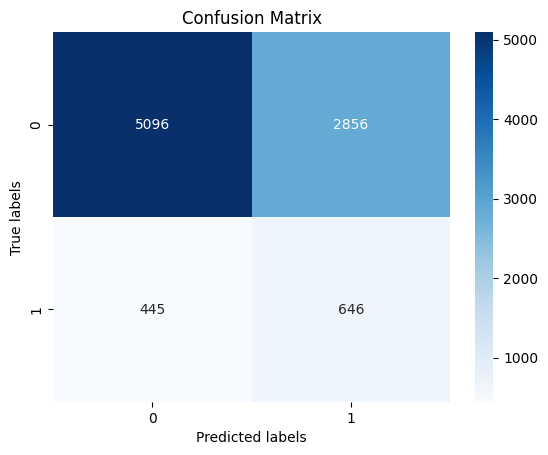

Accuracy: 0.6350
Recall: 0.5921
Precision: 0.1845
F1-score: 0.2813
ROC_AUC: 0.6165



In [31]:
#%% Trực quan hóa confusion matrix
result_summary, cm, accuracy, precision, recall, f1, roc_auc = train_predict_and_evaluate_model(x, y)
def visualize_result(confusion_matrix):
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()
visualize_result(cm)
print('Accuracy: {:.4f}'.format(accuracy))
print('Recall: {:.4f}'.format(recall))
print('Precision: {:.4f}'.format(precision))
print('F1-score: {:.4f}'.format(f1))
print('ROC_AUC: {:.4f}\n'.format(roc_auc))

Optimization terminated successfully.
         Current function value: 0.649442
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649461
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.650645
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.652038
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.649455
         Iterations 6


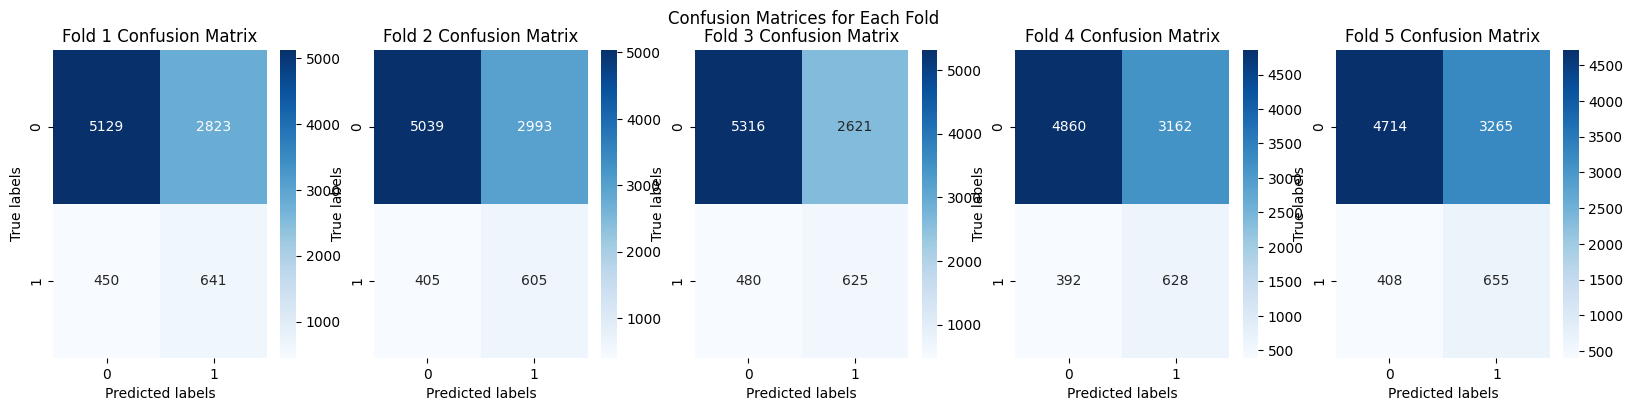

Average Accuracy: 0.6240
Average Recall: 0.5968
Average Precision: 0.1757
Average F1-score: 0.2711
Average ROC-AUC: 0.6123


In [32]:
from sklearn.model_selection import KFold

def kfold_train_predict_and_evaluate_model(x, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    model_scores = []
    confusion_matrices = []
    
    for train_index, test_index in kf.split(x):
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        x_train, y_train = conduct_oversampling(x_train, y_train)
        x_train = sm.add_constant(x_train)
        
        # Fit the logistic regression model
        logit_model = sm.Logit(y_train, x_train)
        result = logit_model.fit()
        
        # Predicting the test set results
        y_pred = result.predict(sm.add_constant(x_test))
        y_pred = (y_pred > 0.5)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        confusion_matrices.append(cm)
        
        # Calculate accuracy, precision, recall, f1-score, and roc-auc
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        
        model_scores.append((accuracy, precision, recall, f1, roc_auc))
    
    # Calculate the average scores across the folds
    avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc = [np.mean(x) for x in zip(*model_scores)]
    
    return result.summary(), confusion_matrices, avg_accuracy, avg_precision, avg_recall, avg_f1, avg_roc_auc

kfold_result_summary, kfold_confusion_matrices, kfold_accuracy, kfold_precision, kfold_recall, kfold_f1, kfold_roc_auc = kfold_train_predict_and_evaluate_model(x, y)

def kfold_visualize_result(confusion_matrices):
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    for i, cm in enumerate(confusion_matrices):
        sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=axes[i])
        axes[i].set_title(f'Fold {i+1} Confusion Matrix')
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
    plt.suptitle('Confusion Matrices for Each Fold')
    plt.show()

kfold_visualize_result(kfold_confusion_matrices)

print('Average Accuracy: {:.4f}'.format(kfold_accuracy))
print('Average Recall: {:.4f}'.format(kfold_recall))
print('Average Precision: {:.4f}'.format(kfold_precision))
print('Average F1-score: {:.4f}'.format(kfold_f1))
print('Average ROC-AUC: {:.4f}'.format(kfold_roc_auc))

In [33]:
# Huấn luyện và lưu mô hình Logistic Regression đa biến
x, y = conduct_oversampling(merged_dataframe[['default', 'balance', 'housing', 'loan']], merged_dataframe['y'])
logistic_model, _, _, _, _, _, _ = train_predict_and_evaluate_model(x, y)
modelname_logistic = "logistic_model.pkl"
with open(modelname_logistic, 'wb') as f:
    pickle.dump(logistic_model, f)

Optimization terminated successfully.
         Current function value: 0.604215
         Iterations 6


##ĐƠN BIẾN

Trường hợp 1: Biến độc lập là biến nhị phân - housing

In [34]:
#%% Oversampling
x_housing, y_housing = merged_dataframe[['housing']],merged_dataframe['y']

In [35]:
#%% Huấn luyện và đánh giá mô hình
train_predict_and_evaluate_model(x_housing,y_housing)


Optimization terminated successfully.
         Current function value: 0.668841
         Iterations 4


(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:                      y   No. Observations:                63940
 Model:                          Logit   Df Residuals:                    63938
 Method:                           MLE   Df Model:                            1
 Date:                Fri, 09 Aug 2024   Pseudo R-squ.:                 0.03507
 Time:                        16:04:44   Log-Likelihood:                -42766.
 converged:                       True   LL-Null:                       -44320.
 Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const          0.4216      0.011     37.877      0.000       0.400       0.443
 housing       -0.8944      0.016    -55.057      0.000      -0.926   

Optimization terminated successfully.
         Current function value: 0.667990
         Iterations 4


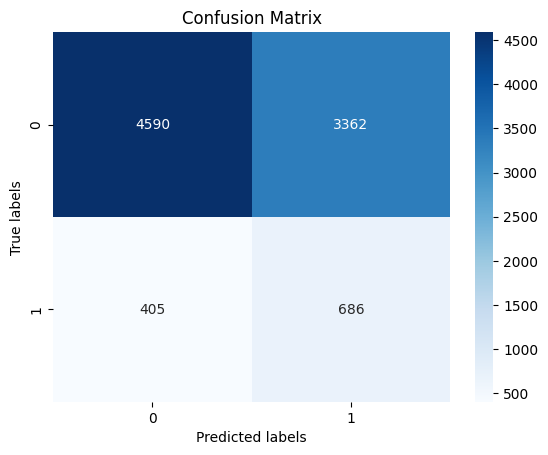

Accuracy: 0.5834
Recall: 0.6288
Precision: 0.1695
F1-score: 0.2670
ROC_AUC: 0.6030



In [36]:
#%% Trực quan hóa kết quả chia 8:2
result_summary_housing, cm_housing, accuracy_housing, precision_housing, recall_housing, f1_housing, roc_auc_housing = train_predict_and_evaluate_model(x_housing,y_housing)
visualize_result(cm_housing)
print('Accuracy: {:.4f}'.format(accuracy_housing))
print('Recall: {:.4f}'.format(recall_housing))
print('Precision: {:.4f}'.format(precision_housing))
print('F1-score: {:.4f}'.format(f1_housing))
print('ROC_AUC: {:.4f}\n'.format(roc_auc_housing))

Optimization terminated successfully.
         Current function value: 0.669116
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669505
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669981
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669976
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.669645
         Iterations 4


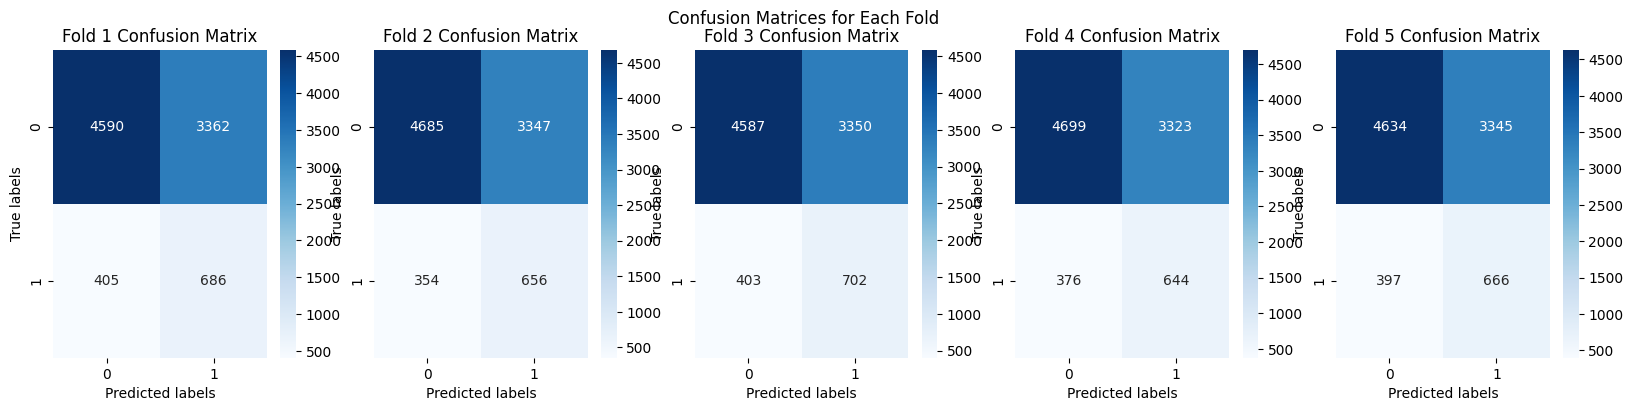

Average Accuracy: 0.5872
Average Recall: 0.6343
Average Precision: 0.1670
Average F1-score: 0.2643
Average ROC-AUC: 0.6076


In [37]:
##Kết quả bằng chia kfold
kfold_result_summary_housing, kfold_cm_housing, kfold_accuracy_housing, kfold_precision_housing, kfold_recall_housing, kfold_f1_housing, kfold_roc_auc_housing = kfold_train_predict_and_evaluate_model(x_housing,y_housing)
kfold_visualize_result(kfold_cm_housing)
print('Average Accuracy: {:.4f}'.format(kfold_accuracy_housing))
print('Average Recall: {:.4f}'.format(kfold_recall_housing))
print('Average Precision: {:.4f}'.format(kfold_precision_housing))
print('Average F1-score: {:.4f}'.format(kfold_f1_housing))
print('Average ROC-AUC: {:.4f}'.format(kfold_roc_auc_housing))

In [38]:
#%% Lưu mô hình
#%% Lưu mô hình Logistic Regression đơn biến (biến độc lập là biến nhị phân)
x_housing, y_housing = conduct_oversampling(merged_dataframe[['housing']], merged_dataframe['y'])
logistic_model_housing, _, _, _, _, _, _ = train_predict_and_evaluate_model(x_housing, y_housing)
modelname_logistic_housing = "logistic_model_housing.pkl"
with open(modelname_logistic_housing, 'wb') as f:
    pickle.dump(logistic_model_housing, f)

Optimization terminated successfully.
         Current function value: 0.670048
         Iterations 4


Trường hợp 2: Biến độc lập là biến liên tục - pdays

In [39]:
#%% Oversampling
x_pdays,y_pdays= merged_dataframe[['pdays']],merged_dataframe['y']

In [40]:
#%% Huấn luyện và đánh giá mô hình
train_predict_and_evaluate_model(x_pdays,y_pdays)

Optimization terminated successfully.
         Current function value: 0.681011
         Iterations 5


(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:                      y   No. Observations:                63940
 Model:                          Logit   Df Residuals:                    63938
 Method:                           MLE   Df Model:                            1
 Date:                Fri, 09 Aug 2024   Pseudo R-squ.:                 0.01751
 Time:                        16:05:02   Log-Likelihood:                -43544.
 converged:                       True   LL-Null:                       -44320.
 Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -0.1520      0.009    -17.183      0.000      -0.169      -0.135
 pdays          0.0030   7.92e-05     37.467      0.000       0.003   

Optimization terminated successfully.
         Current function value: 0.681308
         Iterations 4


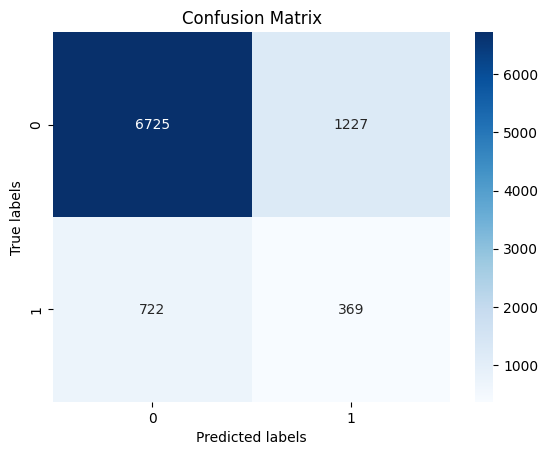

Accuracy: 0.7845
Recall: 0.3382
Precision: 0.2312
F1-score: 0.2747
ROC_AUC: 0.5920



In [41]:
#%% Trực quan hóa kết quả chia 8:2
result_summary_pdays, cm_pdays, accuracy_pdays, precision_pdays, recall_pdays, f1_pdays, roc_auc_pdays = train_predict_and_evaluate_model(x_pdays,y_pdays)
visualize_result(cm_pdays)
print('Accuracy: {:.4f}'.format(accuracy_pdays))
print('Recall: {:.4f}'.format(recall_pdays))
print('Precision: {:.4f}'.format(precision_pdays))
print('F1-score: {:.4f}'.format(f1_pdays))
print('ROC_AUC: {:.4f}\n'.format(roc_auc_pdays))

Optimization terminated successfully.
         Current function value: 0.680991
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.681923
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682187
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.682402
         Iterations 4


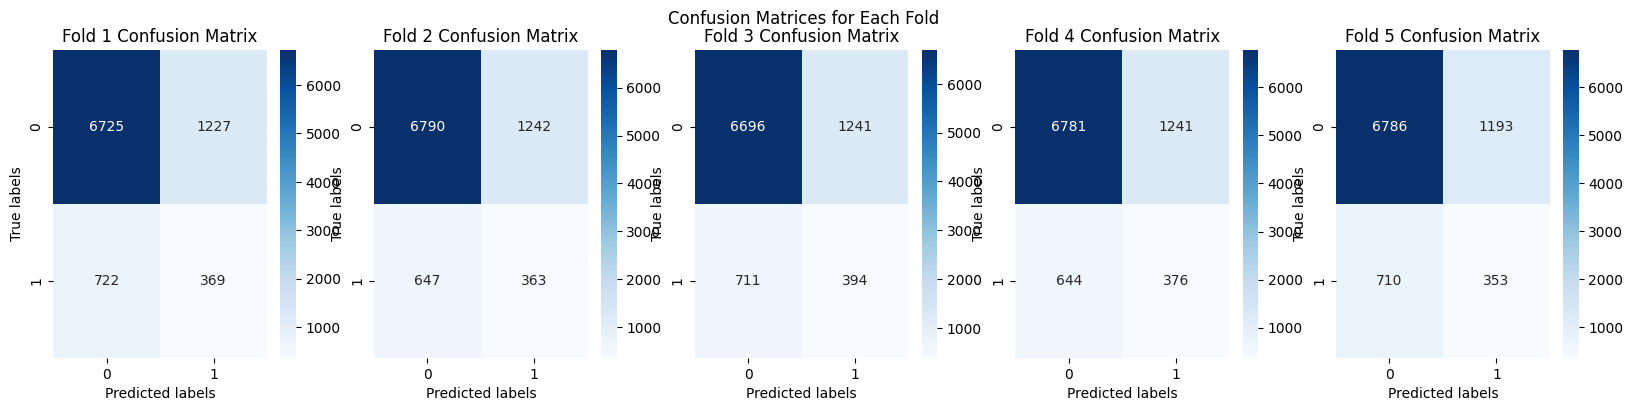

Average Accuracy: 0.7881
Average Recall: 0.3510
Average Precision: 0.2318
Average F1-score: 0.2791
Average ROC-AUC: 0.5985


In [42]:
##Kết quả bằng chia kfold
kfold_result_summary_pdays, kfold_cm_pdays, kfold_accuracy_pdays, kfold_precision_pdays, kfold_recall_pdays, kfold_f1_pdays, kfold_roc_auc_pdays = kfold_train_predict_and_evaluate_model(x_pdays,y_pdays)
kfold_visualize_result(kfold_cm_pdays)
print('Average Accuracy: {:.4f}'.format(kfold_accuracy_pdays))
print('Average Recall: {:.4f}'.format(kfold_recall_pdays))
print('Average Precision: {:.4f}'.format(kfold_precision_pdays))
print('Average F1-score: {:.4f}'.format(kfold_f1_pdays))
print('Average ROC-AUC: {:.4f}'.format(kfold_roc_auc_pdays))

In [43]:
#%% Huấn luyện và lưu mô hình Logistic Regression đơn biến (biến độc lập là biến liên tục)
x_pdays, y_pdays = conduct_oversampling(merged_dataframe[['campaign']], merged_dataframe['y'])
logistic_model_pdays, _, _, _, _, _, _= train_predict_and_evaluate_model(x_pdays, y_pdays)
modelname_logistic_pdays = "logistic_model_pdays.pkl"
with open(modelname_logistic_pdays, 'wb') as f:
    pickle.dump(logistic_model_pdays, f)

Optimization terminated successfully.
         Current function value: 0.682640
         Iterations 5


Trường hợp 3: Biến độc lập là biến thứ bậc - duration

In [44]:
#%% Oversampling
x_duration, y_duration = merged_dataframe[['duration_group_Medium','duration_group_Short']],merged_dataframe['y']

In [45]:
#%% Huấn luyện và đánh giá mô hình
train_predict_and_evaluate_model(x_duration,y_duration)

Optimization terminated successfully.
         Current function value: 0.560979
         Iterations 6


(<class 'statsmodels.iolib.summary.Summary'>
 """
                            Logit Regression Results                           
 Dep. Variable:                      y   No. Observations:                63940
 Model:                          Logit   Df Residuals:                    63937
 Method:                           MLE   Df Model:                            2
 Date:                Fri, 09 Aug 2024   Pseudo R-squ.:                  0.1907
 Time:                        16:05:16   Log-Likelihood:                -35869.
 converged:                       True   LL-Null:                       -44320.
 Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
 -----------------------------------------------------------------------------------------
 const                     1.1543      0.014     80.183      0.000       1.126       1.182
 duration_group_Medium    -1.5570    

Optimization terminated successfully.
         Current function value: 0.561817
         Iterations 6


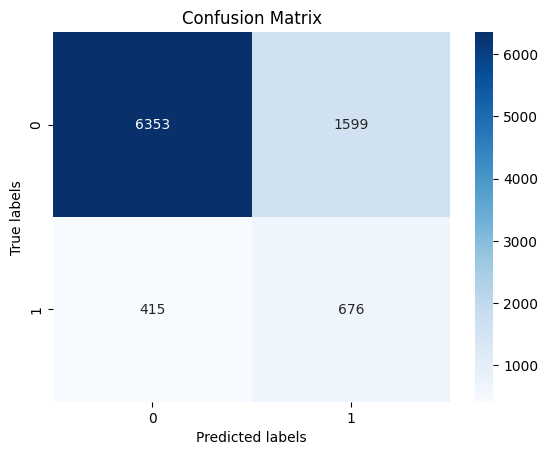

Accuracy: 0.7773
Recall: 0.6196
Precision: 0.2971
F1-score: 0.4017
ROC_AUC: 0.7093



In [46]:
#%% Trực quan hóa kết quả chia 8:2
result_summary_duration, cm_duration, accuracy_duration, precision_duration, recall_duration, f1_duration, roc_auc_duration = train_predict_and_evaluate_model(x_duration,y_duration)
visualize_result(cm_duration)
print('Accuracy: {:.4f}'.format(accuracy_duration))
print('Recall: {:.4f}'.format(recall_duration))
print('Precision: {:.4f}'.format(precision_duration))
print('F1-score: {:.4f}'.format(f1_duration))
print('ROC_AUC: {:.4f}\n'.format(roc_auc_duration))

Optimization terminated successfully.
         Current function value: 0.561904
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562127
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.561534
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.562548
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.565629
         Iterations 6


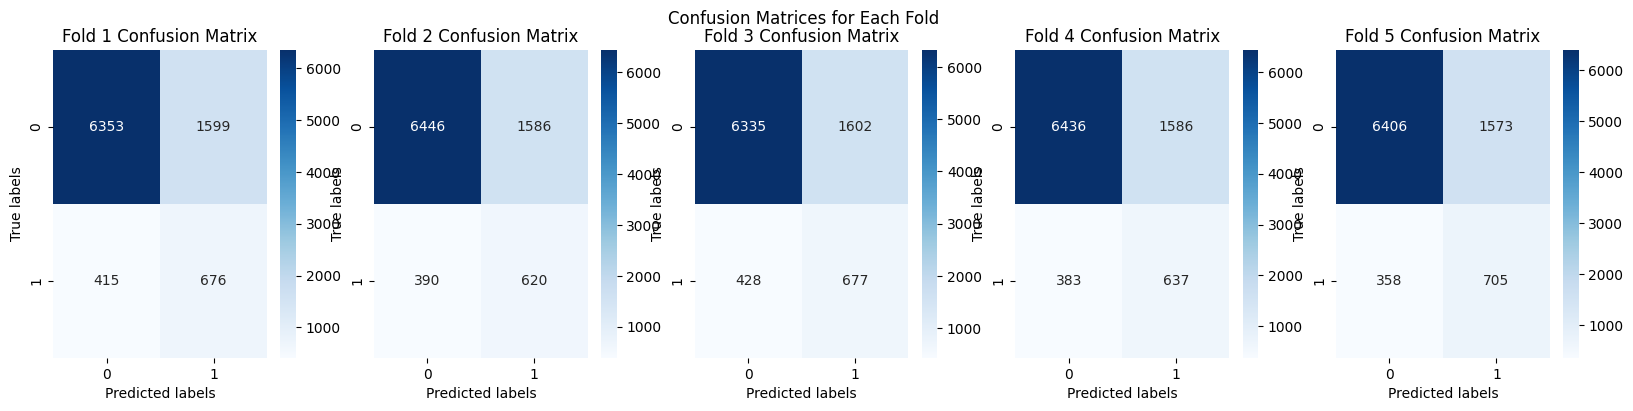

Average Accuracy: 0.7806
Average Recall: 0.6268
Average Precision: 0.2943
Average F1-score: 0.4004
Average ROC-AUC: 0.7139


In [47]:
##Kết quả bằng chia kfold
kfold_result_summary_duration, kfold_cm_duration, kfold_accuracy_duration, kfold_precision_duration, kfold_recall_duration, kfold_f1_duration, kfold_roc_auc_duration = kfold_train_predict_and_evaluate_model(x_duration,y_duration)
kfold_visualize_result(kfold_cm_duration)
print('Average Accuracy: {:.4f}'.format(kfold_accuracy_duration))
print('Average Recall: {:.4f}'.format(kfold_recall_duration))
print('Average Precision: {:.4f}'.format(kfold_precision_duration))
print('Average F1-score: {:.4f}'.format(kfold_f1_duration))
print('Average ROC-AUC: {:.4f}'.format(kfold_roc_auc_duration))

In [49]:
#%% Lưu mô hình Logistic Regression đơn biến (biến độc lập là biến thứ bậc)
x_duration, y_duration = conduct_oversampling(merged_dataframe[['duration_group_Medium','duration_group_Short']],merged_dataframe['y'])
logistic_model_duration, _, _, _, _, _, _ = train_predict_and_evaluate_model(x_duration, y_duration)
modelname_logistic_duration = "logistic_model_duration.pkl"
with open(modelname_logistic_duration, 'wb') as f:
    pickle.dump(logistic_model_duration, f)

Optimization terminated successfully.
         Current function value: 0.561805
         Iterations 6


%%%So sánh kết quả đa biến với DT

In [50]:
#Fit model
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [51]:
# Định nghĩa số lượng fold
k = 5

# Khởi tạo KFold
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Khởi tạo mô hình
model = DecisionTreeClassifier(random_state=42)

# Thực hiện k-fold cross-validation
fold_scores = []
for fold, (train_index, test_index) in enumerate(kf.split(X), 1):
    X_train = x.iloc[train_index]
    y_train = y.iloc[train_index] 
    X_test = x.iloc[test_index]
    y_test = y.iloc[test_index]
    

    sm = SMOTE(random_state=42)
    X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
    
    model = DecisionTreeClassifier(max_depth=5, random_state=42)
    model.fit(X_train_oversampled, y_train_oversampled)
    

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f'For fold {fold}:')
    print(f'Accuracy: {accuracy}')
    print(f'recall: {recall}')
    print(f'precision: {precision}')
    print(f'f-score: {f1}')

mean_accuracy = np.mean(accuracy)
mean_recall = np.mean(recall)
mean_precision = np.mean(precision)
mean_f1 = np.mean(f1)
mean_roc_auc = np.mean(roc_auc)

print('Average Metrics:')
print(f'Accuracy: {mean_accuracy}')
print(f'Recall: {mean_recall}')
print(f'Precision: {mean_precision}')
print(f'F1-score: {mean_f1}')
print(f'ROC-AUC: {mean_roc_auc}')

For fold 1:
Accuracy: 0.6923587305097866
recall: 0.53987167736022
precision: 0.2052980132450331
f-score: 0.29747474747474745
For fold 2:
Accuracy: 0.7073656270736562
recall: 0.5336633663366337
precision: 0.19859985261606486
f-score: 0.2894736842105264
For fold 3:
Accuracy: 0.6399026763990268
recall: 0.5954751131221719
precision: 0.18978944332275743
f-score: 0.2878390201224847
For fold 4:
Accuracy: 0.7109046671090467
recall: 0.5294117647058824
precision: 0.20194465220643232
f-score: 0.292365998917163
For fold 5:
Accuracy: 0.7032736120327361
recall: 0.5164628410159925
precision: 0.20198675496688742
f-score: 0.2903993652472891
Average Metrics:
Accuracy: 0.7032736120327361
Recall: 0.5164628410159925
Precision: 0.20198675496688742
F1-score: 0.2903993652472891
ROC-AUC: 0.6223121323766514
